# N-Gram Models
Based on makemore part 1: https://www.youtube.com/watch?v=PaCmpygFfXo&ab_channel=AndrejKarpathy

### Dependencies & Data

In [1]:
# MAKEMORE TUTORIAL
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
from prettytable import PrettyTable

In [2]:
# DATA 
words = open('./makemore_data/names.txt', 'r').read().splitlines()

print(words[:10])
print(f"length {len(words)}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
length 32033


In [47]:
chars = sorted(list(set(''.join(words)))) 
stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
stoi['.'] = 0 ##just one special character for start and end of word
itos = {i:s for s, i in stoi.items()}

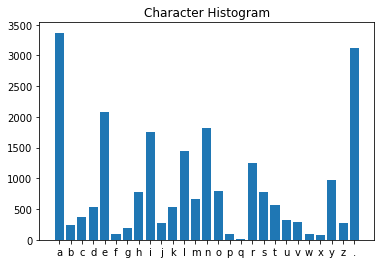

In [189]:
corpus = ''.join(words)
count_letters = dict()

for c in chars:
    count_letters[c] = corpus.count(c)

plt.bar(range(len(n_preds)), list(n_preds.values()), align='center')
plt.xticks(range(len(n_preds)), list(n_preds.keys()))
plt.title("Character Histogram")
plt.show()

# N-Gram model & training pipeline

In [6]:
def create_Ngram_data(words, n):
    alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    stoi = {s:i+1 for i, s in enumerate(alph)} ##create dictionary mapping from char to int
    stoi['.'] = 0 ##just one special character for start and end of word

    xs = []
    ys = []
    for w in words:
        chs = ['.'] + list(w) + ['.']  ##special start and end characters
        if len(chs) < n:
            fill = n - len(chs)
            chs = chs + list('.' for _ in range(fill))
        for name_list in zip(chs[i : i+n] for i in range(len(chs)-(n-1))):
            for s in range(len(name_list)):
                sample = name_list[s]
                temp_x = []
                for cix in range(len(sample)):
                    if cix==len(sample)-1:
                        ys.append(stoi[sample[cix]])
                    else:
                        temp_x.append(stoi[sample[cix]])
                xs.append(temp_x)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    n_samples = xs.shape[0]
    print(f"number of samples: {n_samples}")

    return xs, ys


def split_samples(inputs, labels, frac=0.8, seed=123):
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [13]:
class Ngram:
    def __init__(self, n):

        self.n_inputs = n-1

        alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
        self.stoi = {s:i+1 for i, s in enumerate(alph)} ##create dictionary mapping from char to int
        self.stoi['.'] = 0 ##just one special character for start and end of word
        self.itos = {i:s for s, i in self.stoi.items()}

    def initialize_weights(self, generator, first_letter_neurons=False, xs=None):
        self.first_letter_neurons = first_letter_neurons

        # INITALIZE NETWORK WEIGHTS
        n_inputs = self.n_inputs
        if xs is not None:
            assert n_inputs == xs.shape[1], f"n_inputs ({n_inputs}) does not match the xs.shape[1]"

        W_list = []
        for _ in range(n_inputs):
            W_list.append(torch.randn(size=(27, 27), generator=generator, requires_grad=True))

        if first_letter_neurons:
            W_list.append(torch.randn(size=(27, 1), generator=generator, requires_grad=True))
            # kind of like adding bias but only for the first character..?
        self.W_list = W_list
    

    def forward_pass(self, xs, ys=None, regularization=0):
        # forward pass
        n_samples = xs.shape[0]
        n_inputs = self.n_inputs
        W_list = self.W_list

        ## calculate logits
        logits = torch.zeros((n_samples, 27))
        for ix in range(n_inputs):
            Wi = W_list[ix]
            xi_enc = F.one_hot(xs[:, ix], num_classes=27).float()
            logits += (xi_enc @ Wi)
        if self.first_letter_neurons: ##if including weights on first letter neuron, they are the last in W list
            x1_enc = F.one_hot(xs[:, 0], num_classes=27).float()
            logits += (x1_enc @ W_list[-1]) 

        ##Softmax
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        self.probs = probs

        ##loss
        if ys is not None:
            loss = -probs[torch.arange(n_samples), ys].log().mean()
            for W in W_list:
                loss += regularization*(W**2).mean()
            self.loss = loss
        
            return probs, loss
        else:
             return probs
                

    def backprop_update(self, lr=0.1):
        # backward pass
        for W in self.W_list:
            W.grad = None
        self.loss.backward()

        # update params
        for W in self.W_list:
            W.data += -lr * W.grad ##learning rate


    def generate_words(self, n_words, start_chrs: str = None):
        itos = self.itos
        stoi = self.stoi
        
        n_inputs = self.n_inputs
        out_words = []

        for _ in range(n_words):
            ixlist = [0] 
            word = '.'
            if start_chrs is not None:
                assert len(start_chrs) == n_inputs-1, f"len(start) ({len(start_chrs)}) should be {n_inputs - 1 = }"
                for s in start_chrs:
                    word += s
                    ixlist.append(stoi[s])
            else:
                for ix in range(n_inputs-1):
                    ch_int = torch.randint(1, 26, (1,1), generator=g).item()
                    word += itos[ch_int]
                    ixlist.append(ch_int)

            while True:
                # forward pass
                probs = self.forward_pass(
                    torch.tensor(ixlist).reshape(1, n_inputs)
                    )
                ##Get character
                char_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
                word += itos[char_ix]
                if char_ix == 0: ##if the ix is 0 (special char), then the word ends
                    break
                
                ##Shift characters to predict the next one
                for i in range(n_inputs):
                    ixlist.pop(0) ##drop first char
                    ixlist.append(char_ix) ##append new char to end of list
            out_words.append(word)    
        
        return out_words

# Compare Bigram and Trigram Models

In [7]:
# Create data (for bigram and trigram models)
bi_x, bi_y  = create_Ngram_data(words[:], 2)
tri_x, tri_y = create_Ngram_data(words[:], 3)

number of samples: 228146
number of samples: 196113


In [8]:
# Split bigram data into train, valid, test
train_bix, train_biy, test_bix, test_biy = split_samples(bi_x, bi_y, 0.8)
valid_bix, valid_biy, test_bix, test_biy = split_samples(test_bix, test_biy, 0.5)

print(f"TRAIN SPLIT: {train_bix.shape[0] / bi_x.shape[0] = }")
print(f"VALID SPLIT: {valid_bix.shape[0] / bi_x.shape[0] = }")
print(f"TEST SPLIT: {test_bix.shape[0] / bi_x.shape[0] = }")

TRAIN SPLIT: train_bix.shape[0] / bi_x.shape[0] = 0.7999964934734775
VALID SPLIT: valid_bix.shape[0] / bi_x.shape[0] = 0.10000175326326124
TEST SPLIT: test_bix.shape[0] / bi_x.shape[0] = 0.10000175326326124


In [9]:
# Split trigram data into train, valid, test
train_trix, train_triy, test_trix, test_triy = split_samples(tri_x, tri_y, 0.8)
valid_trix, valid_triy, test_trix, test_triy = split_samples(test_trix, test_triy, 0.5)

print(f"TRAIN SPLIT: {train_trix.shape[0] / tri_x.shape[0] = }")
print(f"VALID SPLIT: {valid_trix.shape[0] / tri_x.shape[0] = }")
print(f"TEST SPLIT: {test_trix.shape[0] / tri_x.shape[0] = }")

TRAIN SPLIT: train_trix.shape[0] / tri_x.shape[0] = 0.7999979603595886
VALID SPLIT: valid_trix.shape[0] / tri_x.shape[0] = 0.09999847026969146
TEST SPLIT: test_trix.shape[0] / tri_x.shape[0] = 0.10000356937071994


In [192]:
# INITIATE MODELS
g = torch.Generator().manual_seed(2147483647)

bigram = Ngram(2)
bigram.initialize_weights(generator=g, first_letter_neurons=True)

trigram = Ngram(3)
trigram.initialize_weights(generator=g, first_letter_neurons=True)


bi_losses, tri_losses, bi_val, tri_val = [], [], [], [] ##to store training updates

In [224]:
# TRAIN
epochs = 500

print("losses:")
for k in range(epochs): #epochs
    
    # forward pass
    _, bi_loss = bigram.forward_pass(train_bix, train_biy) ##BIGRAM
    _, tri_loss = trigram.forward_pass(train_trix, train_triy) ##TRIGRAM
    bi_losses.append(bi_loss.item())
    tri_losses.append(tri_loss.item())

    # validation eval
    _, bi_valloss = bigram.forward_pass(valid_bix, valid_biy, regularization=0) ##BIGRAM
    _, tri_valloss = trigram.forward_pass(valid_trix, valid_triy, regularization=0) ##TRIGRAM
    bi_val.append(bi_valloss.item())
    tri_val.append(tri_valloss.item())

    # backward pass    
    bigram.backprop_update(lr=25) ##BIGRAM
    trigram.backprop_update(lr=25) ##TRIGRAM

    # log updates
    if (k in range(0, epochs, int(epochs*0.10))) or (k==epochs-1):
        print(f"Epoch {k}:", end=" ")
        print(f"BI {round(bi_loss.item(), 5)}", end=" ")
        print(f"TRI {round(tri_loss.item(), 5)}", end=" || ")

losses:
Epoch 0: BI 2.47072 TRI 2.27107 || Epoch 50: BI 2.47023 TRI 2.27064 || Epoch 100: BI 2.46985 TRI 2.27033 || Epoch 150: BI 2.46954 TRI 2.27012 || Epoch 200: BI 2.46929 TRI 2.26997 || Epoch 250: BI 2.46908 TRI 2.26987 || Epoch 300: BI 2.46891 TRI 2.26981 || Epoch 350: BI 2.46877 TRI 2.26978 || Epoch 400: BI 2.46866 TRI 2.26978 || Epoch 450: BI 2.46856 TRI 2.2698 || Epoch 499: BI 2.46848 TRI 2.26983 || 

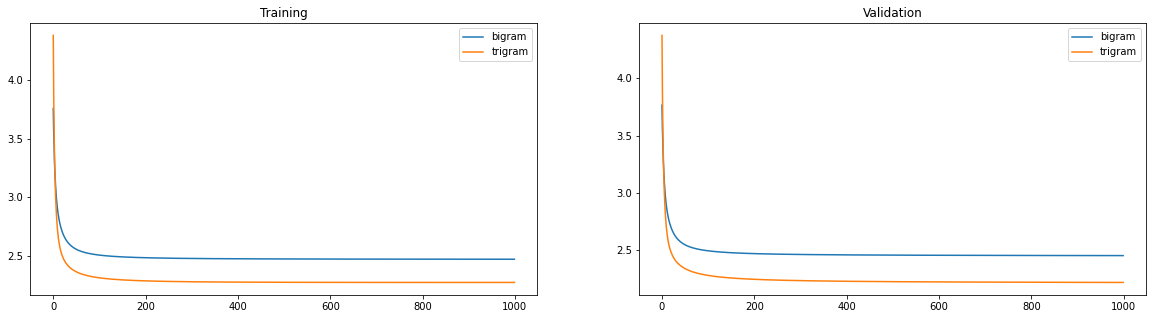

In [225]:
# plot fit history
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax[0].plot(bi_losses, label= 'bigram')
ax[0].plot(tri_losses, label= 'trigram')
ax[0].set_title("Training")
ax[0].legend()

ax[1].plot(bi_val, label = 'bigram')
ax[1].plot(tri_val, label = 'trigram')
ax[1].set_title("Validation")
ax[1].legend()

plt.show()

## Generate some names

In [243]:
# GENERATE NAMES
bi_words = bigram.generate_words(10)
tri_words = trigram.generate_words(10)

t = PrettyTable(["Bigram Words", "Trigram Words"])
for i in range(len(bi_words)):
    t.add_row([bi_words[i], tri_words[i]])

t

Bigram Words,Trigram Words
.cry.,.whunyn.
.blastyn.,.ji.
.pra.,.rumriabriaha.
.khlellvi.,.eakenasoky.
.t.,.ai.
.gh.,.nicely.
.i.,.jaramathele.
.ken.,.re.
.a.,.danakizyve.
.ma.,.eror.


## Some ideas for exploring the test performance

In [244]:
# Look at random characters and what the model would have predicted
samples = 10
t = PrettyTable(['input', 'prediction', '% confidence given to pred', 'truth',  '% confidence given to truth', 'loss'])
for sample, label in zip(test_bix[:samples], test_biy[:samples]):
    probs, loss = bigram.forward_pass(sample.reshape(1, 1), label)
    pred = torch.argmax(probs)
    pred_prob = probs[0][pred.item()].item()
    truth_prob = probs[0][label.item()].item()

    t.add_row([
    itos[sample.item()],
    itos[pred.item()],
    round(pred_prob*100, 3),
    itos[label.item()],
    round(truth_prob*100, 3),
    round(loss.item(), 4)
    ])

t

input,prediction,% confidence given to pred,truth,% confidence given to truth,loss
v,i,33.433,a,24.308,1.4143
h,.,32.704,i,9.725,2.3304
a,.,20.201,r,9.849,2.3178
t,a,17.538,t,5.813,2.845
m,a,43.542,i,16.619,1.7946
m,a,43.542,e,10.849,2.2211
a,.,20.201,.,20.201,1.5994
b,e,27.923,i,5.222,2.9522
l,e,20.816,i,18.936,1.6641
e,.,19.344,t,2.891,3.5436


In [245]:
# Measure the test accuracy of predictions following each character & plot
char_acc = dict()
n_preds = dict()
for l in list(stoi.values())[:]:
    tot_samples = 0
    correct = 0
    n_preds[itos[l]] = 0
    inds = torch.where(test_bix == l)[0]
    for sample, label in zip(test_bix[inds], test_biy[inds]):
        tot_samples += 1
        probs, loss = bigram.forward_pass(sample.reshape(1, 1), label)
        pred = torch.argmax(probs)
        n_preds[itos[l]] += 1
        if pred.item() == label.item(): correct += 1

    char_acc[itos[l]] = correct/tot_samples

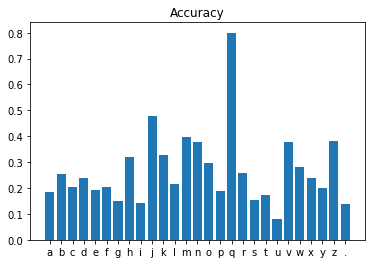

In [246]:
plt.bar(range(len(char_acc)), list(char_acc.values()), align='center')
plt.xticks(range(len(char_acc)), list(char_acc.keys()))
plt.title("Accuracy")
plt.show()

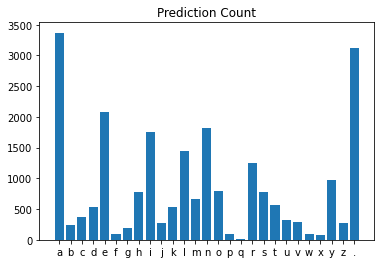

In [247]:
plt.bar(range(len(n_preds)), list(n_preds.values()), align='center')
plt.xticks(range(len(n_preds)), list(n_preds.keys()))
plt.title("Prediction Count")
plt.show()